# Noise audio preprocessing

In [1]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# import necessary functions from the folder "06_Utilities"

cwd = str(Path.cwd()) ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent) ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities") ## full path to the "06_Utilities" folder

# import moduls for audio file processing and mel-spectrogram plotting

sys.path.append(utilities_dir_full_path) ## add the path of the "06_Utilities" folder to the sys.path list
from audioProcessing import processAudio ## modul for audio file processing and mel-spectrogram generation
from spectrogramPlotting import spectrogramPlotter ## modul for mel-spectrogram visualization
from sharedValues import sharedValuesConfig ## modul for shared variables between the classes

# make instances of the classes in the modules
processAudio = processAudio()
spectrogramPlotter = spectrogramPlotter()
sharedValuesConfig = sharedValuesConfig()

In [3]:
# list all audio file datasets in folder "01_Dataset/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir_path = os.path.join(cwd, audio_datasets_main_dir_name) ## path to the "01_audioDatasets" folder
audio_datasets = [] ## list of audio datasets

if os.path.exists(audio_datasets_main_dir_path):
    for i in os.listdir(audio_datasets_main_dir_path):
        ##if folder name does not start with a dot -> to avoid hidden folders
        if i[0] != ".": 
            audio_datasets.append(i) ## add the folder name to the list of audio datasets
    audio_datasets = sorted(audio_datasets) ## sort the list of audio datasets by name
else:
    print("\"01_audioDatasets\" directory does not exist or the path is incorrect.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [4]:
# select the noise dataset

## with the initial folder structure, the noise dataset is the 7th (index 6) in the list

dataset_num = 6 ## ID of the noise audio dataset

print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  07_Noise_Samples


In [5]:
# add all audio files from noise dataset to a list

audio_dataset_dir_path = os.path.join(audio_datasets_main_dir_path, audio_datasets[dataset_num]) ## path to the noise dataset
audio_files = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.m4a')] ## list of audio files in the noise dataset
audio_files_sorted = sorted(audio_files) ## sort the list of audio files by name

print(f"Dataset length: {len(audio_files_sorted)}")

print("First 5 file in the noise dataset:")
for i in range(5): print(f" - {audio_files_sorted[i]}")

Dataset length: 14
First 5 file in the noise dataset:
 - 01_Reference_level_production.m4a
 - 02_Screws.m4a
 - 03_Hex_keys.m4a
 - 04_Plastic_part.m4a
 - 05_Screw_drivers.m4a


In [6]:
# shared parameters used in the project

sampling_rate = sharedValuesConfig.SAMPLING_RATE ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX ## maximum frequency in Hz
dB_ref = sharedValuesConfig.DB_REF ## reference value for dB conversion
a_squere_min = sharedValuesConfig.A_SQUERE_MIN ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS ## maximum dB value

In [1]:
# plot the wave and dB-mel-spectrogram of an audio file from the noise dataset

file_id_num = 0 ## selected file ID number

print(f"Selected file: {audio_files_sorted[file_id_num]}") ## print the name of the selected audio file

## check if the selected file ID number is in the range of the noise dataset and plot the wave and mel-spectrogram
if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir_path, audio_files_sorted[file_id_num]) ## path to the selected audio file
    ## get the wave and mel-spectrogram data
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    ## plot the wave and mel-spectrogram
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range") ## print an error message if the selected file ID number is out of range

NameError: name 'audio_files_sorted' is not defined

In [2]:
# window parameters for splitting all audio files into chunks

## short window size for the connectors Ethernet and HVA 630
time_interval = sharedValuesConfig.WINDOW_SIZE_SEC ## time interval in seconds
window_size_sec = sharedValuesConfig.WINDOW_SIZE_SEC ## window size in seconds
window_size = sharedValuesConfig.WINDOW_SIZE ## spectrogram columns in the window
step_size_sec = sharedValuesConfig.STEP_SIZE_SEC ## step size in seconds
step_size = sharedValuesConfig.STEP_SIZE ## spectrogram columns in the step

## long window size for the connector HVA 280
window_size_long = sharedValuesConfig.WINDOW_SIZE_LONG ## spectrogram columns in the long window, 2 x the short window size

## print the window parameters
print(f"Short window size: {window_size} columns") 
print(f"Long window size: {window_size_long} columns")
print(f"Step size: {step_size} columns")

NameError: name 'sharedValuesConfig' is not defined

In [ ]:
# calculate the maximum dB value of the reference background noise audio file recorded in the production environment
## this value will be then used for the threshold to select the chunks from the noise audio files which contain noise events above the threshold

file_id_num = 0 ## ID of the reference background noise audio file in the dataset
audio_file_path = os.path.join(audio_dataset_dir_path, audio_files_sorted[file_id_num]) ## path to the reference background noise audio file

## get the wave and mel-spectrogram data
signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)

## calculate the maximum dB value of the reference background noise audio file
max_dB_reference = np.max(D_mel_dB)
max_dB_reference

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/05_Utilities/audioProcessing.py:53: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


-28.197819

In [ ]:
# get audio spectrograms for all audio files in the noise dataset except the reference background noise audio file

audio_files_except_ref = audio_files_sorted.copy()
audio_files_except_ref.pop(0) ## remove the reference audio file from the beginning of the list

## create empty lists for mel-spectrograms, wave forms, and time values
spectrograms = [] ## list of mel-spectrograms
signals = [] ## list of wave forms
signal_times = [] ## list of time values

## iterate through all audio files in the noise dataset and get the mel-spectrograms, wave forms, and time values
for audio_file in audio_files_except_ref:
    audio_file_path = os.path.join(audio_dataset_dir_path, audio_file)

    ## get the wave and mel-spectrogram data
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)

    ## append the mel-spectrogram, wave form, and time value to the corresponding lists
    spectrograms.append(D_mel_dB)
    signals.append(signal)
    signal_times.append(time)


In [ ]:
# create spectrogram chunks and corresponding labels (all labels = 0) for the noise dataset (excluding the reference noise file)

spec_chunk_dataset = [] ## list of spectrogram chunks, WxH = 32x128  (with the current parameters)
spec_chunk_labels = [] ## list of labels
signal_chunks = [] ## list of wave signal chunks
time_chunks = [] ## list of time chunks

spec_chunk_dataset_long_window = [] ## list of long spectrogram chunks, WxH = 64x128  (with the current parameters)
spec_chunk_labels_long_window = [] ## list of labels for long spectrogram chunks
signal_chunks_long_window = [] ## list of wave signal chunks for long window
time_chunks_long_window = [] ## list of time chunks for long window

dB_threshold = max_dB_reference + abs(max_dB_reference) * 0.3 # dB threshold above a chunk considered as containing a noise event

## create spectrogram datasets for the connectors Ethernet and HVA 630
def createSpectrogramDataset(spectrograms, signals, signal_times):
    ## iterate through all audio file spectrograms in the noise dataset
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i] ## spectrogram of the i-th audio file
        signal = signals[i] ## wave form of the i-th audio file
        time = signal_times[i] ## time values of the i-th audio file

        ## iterate through the spectrogram columns with the step size
        ## start_idx - start index of the window, end_idx - end index of the window
        ## total spectrogram columns: spectrogram.shape[1]
        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size ## end index of the window
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx] ## get the spectrogram chunk
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length] ## get the wave signal chunk, hop_length is the number of samples between successive frames in the STFT
            time_chunk = time[start_idx*hop_length : end_idx*hop_length] ## get the time chunk
            
            label = 0 # all chunk labeled with 0 as non of them contain a click event

            if np.max(spectrogram_chunk) > dB_threshold:
                spec_chunk_dataset.append(spectrogram_chunk)
                spec_chunk_labels.append(label)
                signal_chunks.append(signal_chunk)
                time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

## create spectrogram datasets for the connector HVA 280
## same process as above but with the long window size
def createSpectrogramDatasetLongWindow(spectrograms, signals, signal_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]

        for start_idx in range(0, spectrogram.shape[1] - window_size_long, step_size):
            end_idx = start_idx + window_size_long
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            label = 0 # no click event

            if np.max(spectrogram_chunk) > dB_threshold:
                spec_chunk_dataset_long_window.append(spectrogram_chunk)
                spec_chunk_labels_long_window.append(label)
                signal_chunks_long_window.append(signal_chunk)
                time_chunks_long_window.append(time_chunk)

    return spec_chunk_dataset_long_window, spec_chunk_labels_long_window, signal_chunks_long_window, time_chunks_long_window

## create the spectrogram datasets for the connectors Ethernet and HVA 630
spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times)

## create the spectrogram datasets for the connector HVA 280
spec_chunk_dataset_long_window, spec_chunk_labels_long_window, signal_chunks_long_window, time_chunks_long_window = createSpectrogramDatasetLongWindow(spectrograms, signals, signal_times)

print(len(spec_chunk_dataset)) # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels

print(len(spec_chunk_dataset_long_window)) # number of spectrogram chunks in long window dataset
print(len(spec_chunk_labels_long_window)) # number of labels in long window dataset

2538
2538
4026
4026


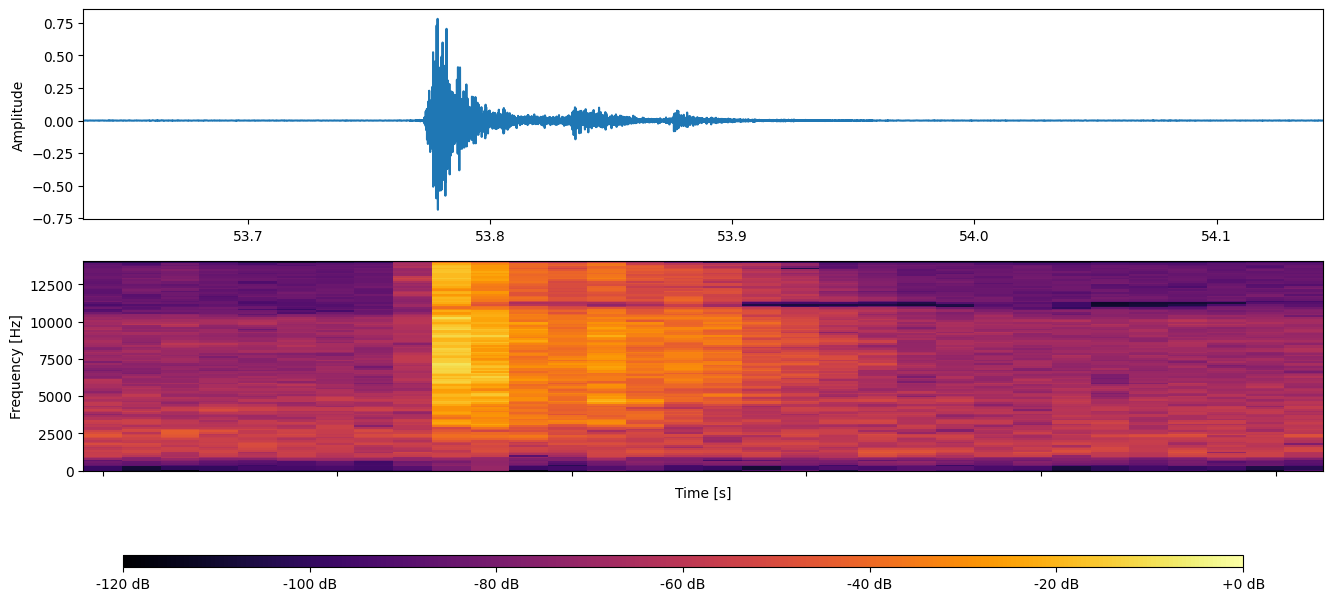

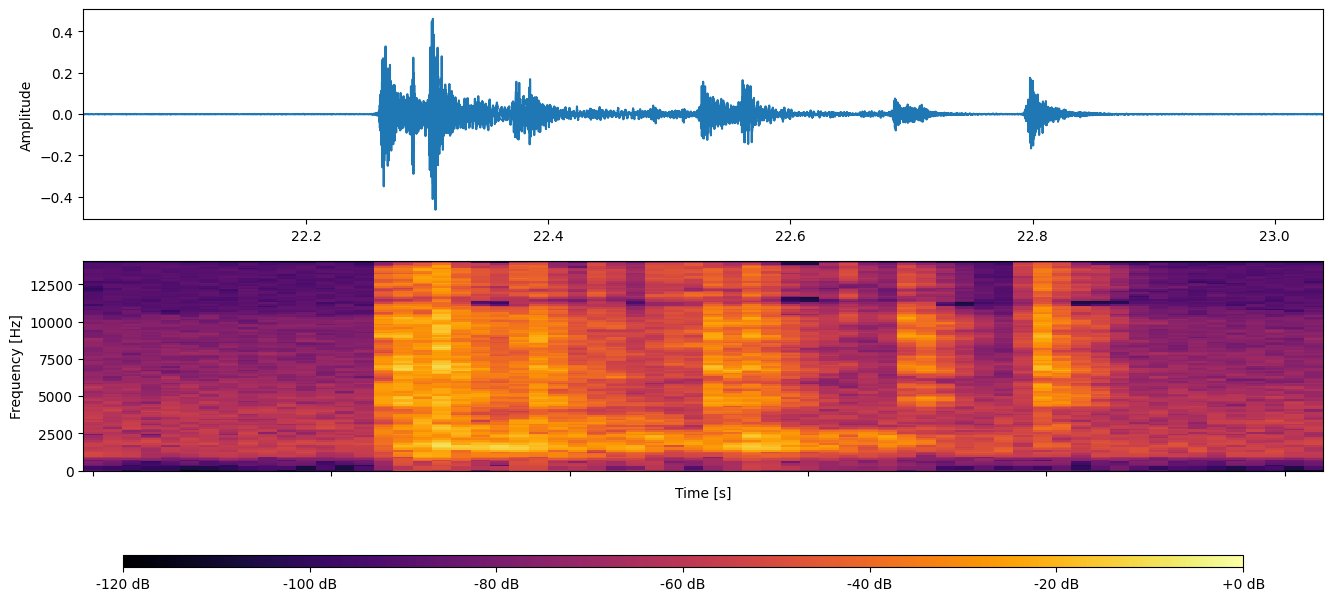

In [ ]:
# plot one chunk from the dataset

chunk_id_to_plot = 2300

if chunk_id_to_plot < len(spec_chunk_dataset):
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("Chunk ID out of range")


# plot one chunk from the long window dataset

if chunk_id_to_plot < len(spec_chunk_dataset_long_window):
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks_long_window[chunk_id_to_plot], time_chunks_long_window[chunk_id_to_plot], spec_chunk_dataset_long_window[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("Chunk ID out of range")



In [ ]:
# save the noise spectrogram dataset and labels in .npz format into the same directory as the noise audio files

save_directory = audio_dataset_dir_path ## directory to save the noise dataset
filename = "noise_dataset.npz"
filename_long_window = "noise_dataset_long_window.npz"

file_fullpath = os.path.join(save_directory, filename) ## full path to save the noise dataset
file_fullpath_long_window = os.path.join(save_directory, filename_long_window) ## full path to save the noise dataset with long window size

spec_chunk_dataset = np.array(spec_chunk_dataset) ## convert the list of spectrogram chunks to a numpy array
spec_chunk_labels = np.array(spec_chunk_labels) ## convert the list of labels to a numpy array

spec_chunk_dataset_long_window = np.array(spec_chunk_dataset_long_window) ## convert the list of long spectrogram chunks to a numpy array
spec_chunk_labels_long_window = np.array(spec_chunk_labels_long_window) ## convert the list of labels for long spectrogram chunks to a numpy array

## save both datasets
np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)
np.savez(file_fullpath_long_window, spec_chunks=spec_chunk_dataset_long_window, labels=spec_chunk_labels_long_window)

(128, 32)
2538
2538


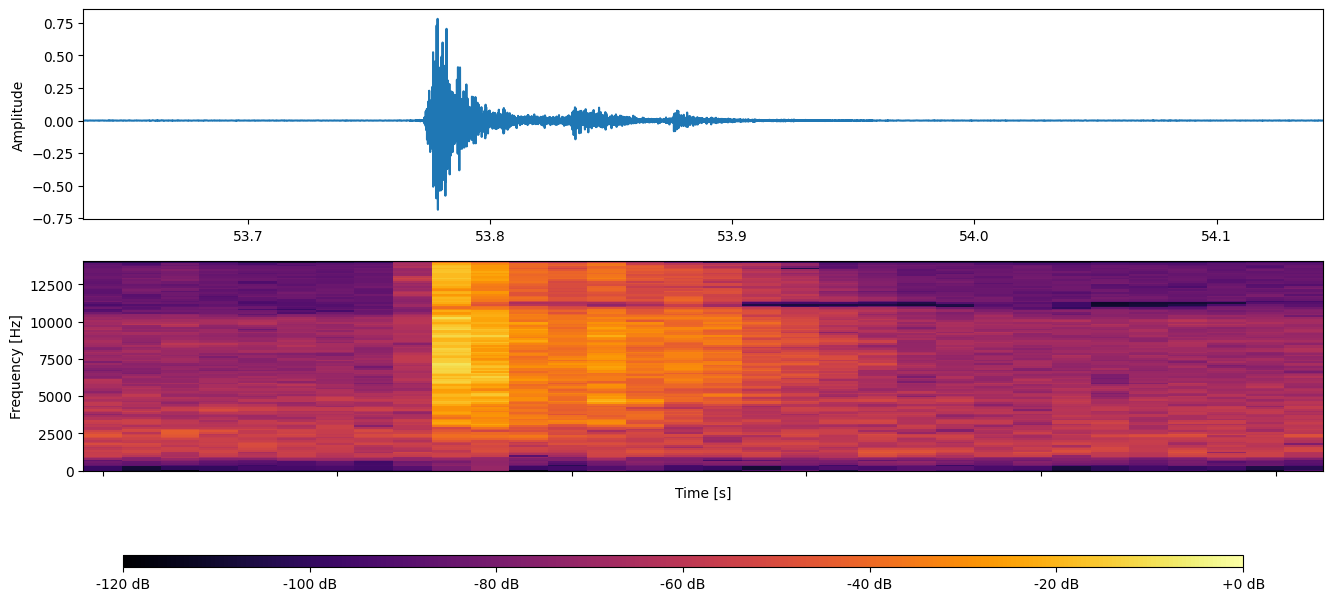

In [ ]:
# check if saving was successful by loading the saved dataset and plotting one chunk

## load the saved dataset
data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

## print dataset parameters
print(f"chunk shape: {loaded_chunks[0].shape}")
print(f"number of chunks: {len(loaded_chunks)}")
print(f"number of labels: {len(loaded_labels)}")

# plot out one spectrogram chunk, same as above
spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)